In [457]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
%matplotlib inline  

In [458]:
def parse_time_string_moy(time_string):
    date_time_obj = datetime.strptime(str(time_string).split(".")[0], '%Y-%m-%d %H:%M:%S')
    moy = date_time_obj.month
    return moy

def parse_time_string_dow(time_string):
    date_time_obj = datetime.strptime(str(time_string).split(".")[0], '%Y-%m-%d %H:%M:%S')
    dow = date_time_obj.weekday()
    return dow

def parse_time_string_hod(time_string):
    date_time_obj = datetime.strptime(str(time_string).split(".")[0], '%Y-%m-%d %H:%M:%S')
    hod = date_time_obj.hour
    return hod

In [435]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [469]:
data_source = './QD.xlsx'#,'./QD.xlsx''./LSM.xlsx'
myData = pd.read_excel(data_source,sheet_name = '2019')
myData_2020 = pd.read_excel(data_source,sheet_name='normal_2020')
myData_COVID = pd.read_excel(data_source,sheet_name = 'covid time')
print(myData.loc[:,'Unnamed: 0'].apply(parse_time_string_moy).unique())
print(myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_moy).unique())
print(myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_moy).unique())
myData.columns, myData_2020.columns, myData_COVID.columns

[1 2]
[1]
[1 2]


(Index(['Unnamed: 0', 'SO4', 'NO3', 'OOA', 'Temp', 'RH', 'WD', 'WS', 'Pressure',
        'Ox'],
       dtype='object'),
 Index(['Unnamed: 0', 'SO4', 'NO3', 'OOA', 'Temp', 'RH', 'WD', 'WS', 'Pressure',
        'Ox'],
       dtype='object'),
 Index(['Unnamed: 0', 'SO4', 'NO3', 'OOA', 'Temp', 'RH', 'WD', 'WS', 'Pressure',
        'Ox'],
       dtype='object'))

In [447]:
for data_source in ['./QD.xlsx']: ##'./LSM.xlsx', no month-of-year
    print("------------ evaluating:",data_source)
    responses = ['SO4', 'NO3','OOA']
    myData = pd.read_excel(data_source,sheet_name = '2019')
    myData_2020 = pd.read_excel(data_source,sheet_name='normal_2020')
    myData_COVID = pd.read_excel(data_source,sheet_name = 'covid time')
    print(myData.shape, myData_COVID.shape)
    myData['month_of_year'] = myData.loc[:,'Unnamed: 0'].apply(parse_time_string_moy)
    myData['day_of_week'] = myData.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData['hour_of_day'] = myData.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)
    
    myData_2020['month_of_year'] = myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_moy)
    myData_2020['day_of_week'] = myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData_2020['hour_of_day'] = myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)

    myData_COVID['month_of_year'] = myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_moy)
    myData_COVID['day_of_week'] = myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData_COVID['hour_of_day'] = myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)
#     if data_source == './QD.xlsx':
#         myData = myData.drop(['NOx'], axis=1)
#     myData_COVID = myData_COVID.drop(['Unnamed: 12'], axis=1)
    #print(myData.columns,myData_COVID.columns)
    myData = myData.dropna()
    myData_2020 = myData_2020.dropna()
    myData_COVID = myData_COVID.dropna()
    #print(myData.shape, myData_2020.shape, myData_COVID.shape)
    #print(X.isnull().any())

    my_predictors = ['Temp', 'RH', 'WD', 'WS', 'Pressure','Ox']
    X = myData[my_predictors]
    X_2020 = myData_2020[my_predictors]
    X_COVID = myData_COVID[my_predictors]
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X = pd.DataFrame(scaler.fit_transform(X), columns=my_predictors)
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X_2020 = pd.DataFrame(scaler.fit_transform(X_2020), columns=my_predictors)
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X_COVID = pd.DataFrame(scaler.fit_transform(X_COVID), columns=my_predictors)

    X.loc[:,'month_of_year'] = myData.loc[:,'month_of_year'].values
    X.loc[:,'day_of_week'] = myData.loc[:,'day_of_week'].values
    X.loc[:,'hour_of_day'] = myData.loc[:,'hour_of_day'].values
    
    X_2020.loc[:,'month_of_year'] = myData_2020.loc[:,'month_of_year'].values
    X_2020.loc[:,'day_of_week'] = myData_2020.loc[:,'day_of_week'].values
    X_2020.loc[:,'hour_of_day'] = myData_2020.loc[:,'hour_of_day'].values
    
    X_COVID.loc[:,'month_of_year'] = myData_COVID.loc[:,'month_of_year'].values
    X_COVID.loc[:,'day_of_week'] = myData_COVID.loc[:,'day_of_week'].values
    X_COVID.loc[:,'hour_of_day'] = myData_COVID.loc[:,'hour_of_day'].values

    X = pd.get_dummies(X, columns=[ 'month_of_year','day_of_week', 'hour_of_day'])
    X_2020 = pd.get_dummies(X_2020, columns=[ 'month_of_year','day_of_week', 'hour_of_day'])
    X_COVID = pd.get_dummies(X_COVID,columns=['month_of_year','day_of_week', 'hour_of_day'])

    param_grid = [
            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
    
    with open(data_source.split(".")[1][1:]+"_R2.txt","w+") as fp:
        for response in responses:
            y = myData.loc[:,[response]]
            regr = RandomForestRegressor()
            #regr.fit(X,y.values.ravel())
            #scores = cross_validate(regr,X,y.values.ravel(),scoring='r2',cv=10)
            #print(scores['train_score'].mean(),scores['test_score'].mean())
            grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
            grid_search.fit(X,y.values.ravel())
            print(grid_search.best_params_)
            evaluate(grid_search.best_estimator_, X, y.values.ravel())
            #print("{:.2f}".format(np.sqrt(-grid_search.cv_results_['mean_test_score'].max())))
            y_pred = grid_search.best_estimator_.predict(X)
            y_pred_2020 = grid_search.best_estimator_.predict(X_2020)
            y_pred_COVID = grid_search.best_estimator_.predict(X_COVID)
            myData_COVID["predicted_"+response] = y_pred_COVID
            myData["predicted_"+response] = y_pred
            myData_2020["predicted_"+response] = y_pred_2020
            fp.write(str(response)+": "+str(r2_score(y,y_pred))+"\n")
    fp.close()
    myData_2020.to_csv("predicted_"+data_source.split(".")[1][1:]+"_2020.csv", index=False)

------------ evaluating: ./QD.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dty

{'max_features': 6, 'n_estimators': 200}
Model Performance
Average Error: 0.6767 degrees.
Accuracy = -inf%.


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


ValueError: Number of features of the model must match the input. Model n_features is 39 and input n_features is 38 

In [448]:
myData_2020.month_of_year.unique()

array([1])

In [443]:
data_source

'./TY.xlsx'

In [454]:
X_2020.Ox.values/2.0

array([-0.31870993, -0.10785759,  0.18206439,  0.26113401,  0.57741253,
        0.76190833,  0.94640413,  1.10454339,  1.20996956, -0.10785759,
       -0.0551445 , -0.21328376,  0.55105599,  0.60376907,  0.47198636,
        0.36656019,  0.28749056,  0.1293513 ,  0.05028167, -0.08150104,
       -0.18692722, -0.21328376, -0.21328376, -0.37142302, -0.31870993,
       -0.95126696, -0.18692722,  0.02392513,  0.07663821,  0.1293513 ,
        0.3138471 ,  0.44562982,  0.41927327,  0.39291673, -0.52956228,
       -0.02878796, -0.13421413, -0.02878796, -0.02878796, -0.0551445 ,
       -0.13421413, -0.13421413, -0.16057067, -0.18692722, -0.21328376,
       -0.21328376, -0.2396403 , -0.2396403 , -0.29235339, -0.18692722,
       -0.08150104, -0.10785759, -0.10785759, -0.13421413, -0.10785759,
       -0.10785759, -0.10785759, -0.0551445 , -0.13421413, -0.13421413,
       -0.10785759, -0.13421413, -0.13421413, -0.13421413, -0.13421413,
       -0.16057067, -0.16057067, -0.2396403 , -0.31870993, -0.31

In [456]:
for data_source in ['./LSM.xlsx','./HZW.xlsx','./TY.xlsx','./SX.xlsx','./CC.xlsx','./QD.xlsx']: ##'no month-of-year
    print("------------ evaluating:",data_source)
    responses = ['SO4', 'NO3','OOA']
    myData = pd.read_excel(data_source,sheet_name = '2019')
    myData_2020 = pd.read_excel(data_source,sheet_name='normal_2020')
    myData_COVID = pd.read_excel(data_source,sheet_name = 'covid time')
    print(myData.shape, myData_COVID.shape)
    myData['day_of_week'] = myData.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData['hour_of_day'] = myData.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)
    
    myData_2020['day_of_week'] = myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData_2020['hour_of_day'] = myData_2020.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)

    myData_COVID['day_of_week'] = myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_dow)
    myData_COVID['hour_of_day'] = myData_COVID.loc[:,'Unnamed: 0'].apply(parse_time_string_hod)
#     if data_source == './QD.xlsx':
#         myData = myData.drop(['NOx'], axis=1)
#     myData_COVID = myData_COVID.drop(['Unnamed: 12'], axis=1)
    #print(myData.columns,myData_COVID.columns)
    myData = myData.dropna()
    myData_2020 = myData_2020.dropna()
    myData_2020.loc[:,'Ox'] = myData_2020.Ox.values/2.0
    myData_COVID = myData_COVID.dropna()
    #print(myData.shape, myData_2020.shape, myData_COVID.shape)
    #print(X.isnull().any())

    my_predictors = ['Temp', 'RH', 'WD', 'WS', 'Pressure','Ox']
    X = myData[my_predictors]
    X_2020 = myData_2020[my_predictors]
    X_COVID = myData_COVID[my_predictors]
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X = pd.DataFrame(scaler.fit_transform(X), columns=my_predictors)
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X_2020 = pd.DataFrame(scaler.fit_transform(X_2020), columns=my_predictors)
    
    
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    X_COVID = pd.DataFrame(scaler.fit_transform(X_COVID), columns=my_predictors)

    X.loc[:,'day_of_week'] = myData.loc[:,'day_of_week'].values
    X.loc[:,'hour_of_day'] = myData.loc[:,'hour_of_day'].values
    
    X_2020.loc[:,'day_of_week'] = myData_2020.loc[:,'day_of_week'].values
    X_2020.loc[:,'hour_of_day'] = myData_2020.loc[:,'hour_of_day'].values
    
    X_COVID.loc[:,'day_of_week'] = myData_COVID.loc[:,'day_of_week'].values
    X_COVID.loc[:,'hour_of_day'] = myData_COVID.loc[:,'hour_of_day'].values

    X = pd.get_dummies(X, columns=['day_of_week', 'hour_of_day'])
    X_2020 = pd.get_dummies(X_2020, columns=[ 'day_of_week', 'hour_of_day'])
    X_COVID = pd.get_dummies(X_COVID,columns=['day_of_week', 'hour_of_day'])

    param_grid = [
            {'n_estimators': [60,80,100,120,160,200], 'max_features': [6,12,18,24]},
    ]
    
    with open(data_source.split(".")[1][1:]+"_R2.txt","w+") as fp:
        for response in responses:
            y = myData.loc[:,[response]]
            regr = RandomForestRegressor()
            #regr.fit(X,y.values.ravel())
            #scores = cross_validate(regr,X,y.values.ravel(),scoring='r2',cv=10)
            #print(scores['train_score'].mean(),scores['test_score'].mean())
            grid_search =  GridSearchCV(regr,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)
            grid_search.fit(X,y.values.ravel())
            print(grid_search.best_params_)
            evaluate(grid_search.best_estimator_, X, y.values.ravel())
            #print("{:.2f}".format(np.sqrt(-grid_search.cv_results_['mean_test_score'].max())))
            y_pred = grid_search.best_estimator_.predict(X)
            y_pred_2020 = grid_search.best_estimator_.predict(X_2020)
            y_pred_COVID = grid_search.best_estimator_.predict(X_COVID)
            myData_COVID["predicted_"+response] = y_pred_COVID
            myData["predicted_"+response] = y_pred
            myData_2020["predicted_"+response] = y_pred_2020
            fp.write(str(response)+": "+str(r2_score(y,y_pred))+"\n")
    fp.close()
    myData_2020.to_csv("predicted_"+data_source.split(".")[1][1:]+"_half_Ox_2020.csv", index=False)

------------ evaluating: ./LSM.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 18, 'n_estimators': 80}
Model Performance
Average Error: 0.6075 degrees.
Accuracy = 84.29%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 18, 'n_estimators': 60}
Model Performance
Average Error: 0.8669 degrees.
Accuracy = 77.85%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 24, 'n_estimators': 200}
Model Performance
Average Error: 0.6549 degrees.
Accuracy = 87.53%.
------------ evaluating: ./HZW.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


{'max_features': 6, 'n_estimators': 100}
Model Performance
Average Error: 0.5887 degrees.
Accuracy = 89.56%.
{'max_features': 6, 'n_estimators': 60}
Model Performance
Average Error: 1.5457 degrees.
Accuracy = 77.96%.
{'max_features': 12, 'n_estimators': 120}
Model Performance
Average Error: 0.7004 degrees.
Accuracy = 87.19%.
------------ evaluating: ./TY.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of th

{'max_features': 12, 'n_estimators': 120}
Model Performance
Average Error: 0.4998 degrees.
Accuracy = 88.69%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 60}
Model Performance
Average Error: 1.2443 degrees.
Accuracy = 81.25%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 100}
Model Performance
Average Error: 0.9312 degrees.
Accuracy = 87.72%.
------------ evaluating: ./SX.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of th

{'max_features': 6, 'n_estimators': 80}
Model Performance
Average Error: 0.6532 degrees.
Accuracy = 90.70%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 60}
Model Performance
Average Error: 1.0723 degrees.
Accuracy = 84.37%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 12, 'n_estimators': 120}
Model Performance
Average Error: 0.6799 degrees.
Accuracy = 89.28%.
------------ evaluating: ./CC.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of th

{'max_features': 6, 'n_estimators': 80}
Model Performance
Average Error: 0.7726 degrees.
Accuracy = 82.11%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 80}
Model Performance
Average Error: 1.3185 degrees.
Accuracy = 70.02%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 200}
Model Performance
Average Error: 0.7418 degrees.
Accuracy = 83.49%.
------------ evaluating: ./QD.xlsx
(1119, 10) (744, 10)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of th

{'max_features': 6, 'n_estimators': 200}
Model Performance
Average Error: 0.7737 degrees.
Accuracy = -inf%.


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 100}
Model Performance
Average Error: 1.2978 degrees.
Accuracy = -5.29%.


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 6, 'n_estimators': 100}
Model Performance
Average Error: 0.8533 degrees.
Accuracy = 72.01%.


In [406]:
myData_COVID.month_of_year.unique()

array([1, 2])

In [397]:
pd.get_dummies(X,columns=['day_of_week']).columns

Index(['Temp', 'RH', 'WD', 'WS', 'Pressure', 'month_of_year', 'hour_of_day',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')

In [399]:
myData_COVID['day_of_week'].shape, X_COVID['day_of_week'].shape

((665,), (665,))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f734173b0f0>,
      dtype=object)

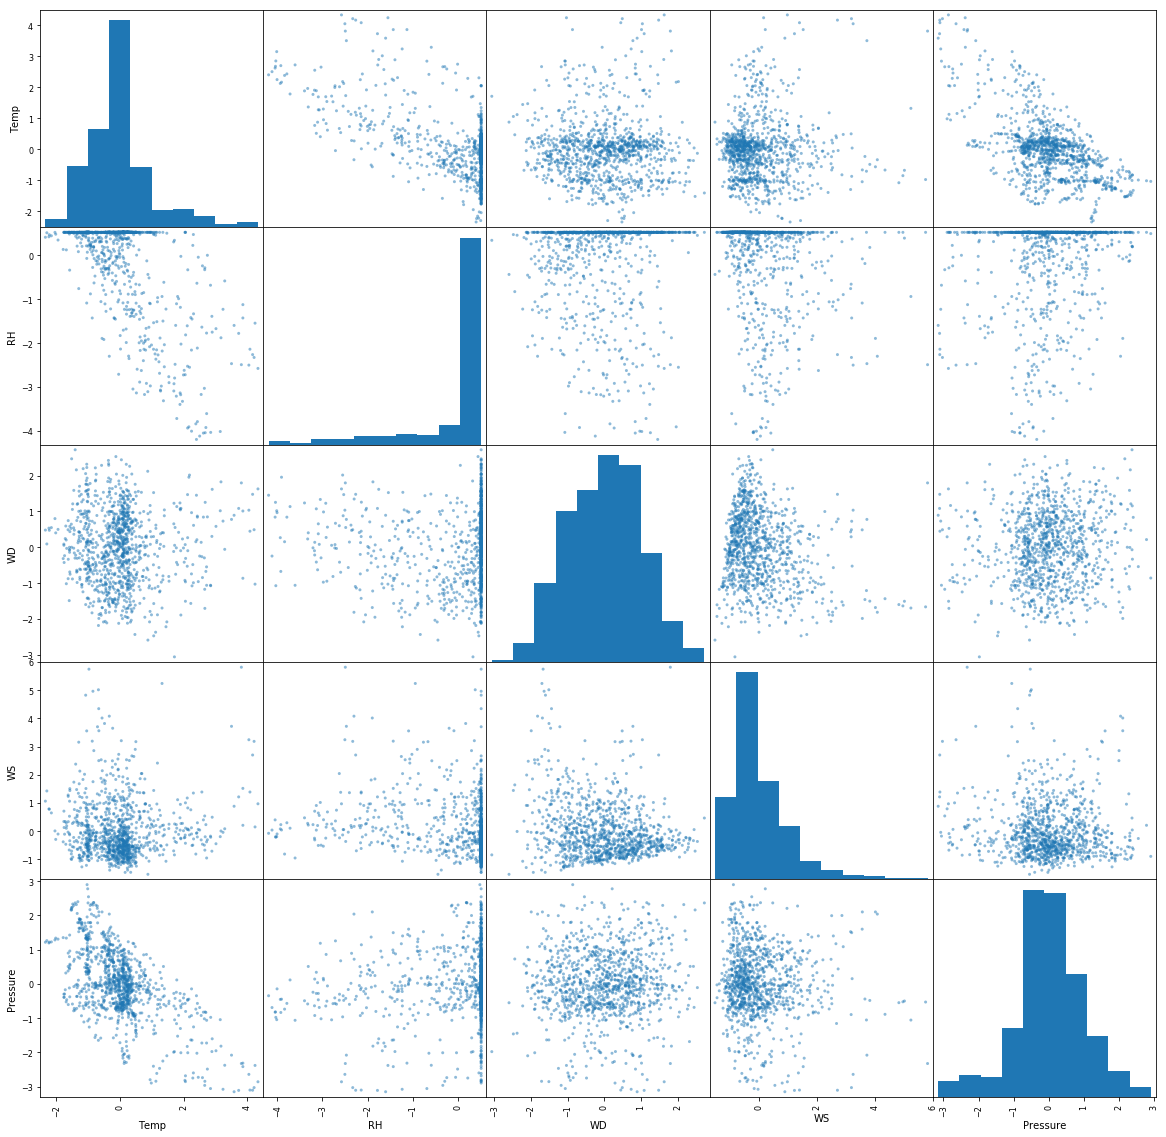

In [333]:
scatter_matrix(X[my_predictors], figsize=(20,20))

In [130]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.04,
                 max_depth=15,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
my_model = model.fit(X_train, y_train,)
y_pred = my_model.predict(X_test)
print(mean_squared_error(y_test,y_pred))
y_pred_2020 = my_model.predict(X_2020)
y_pred_COVID = my_model.predict(X_COVID)

[01:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6.278949937462103


2.1427799227799227


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'NO2, 2020 COVID period')

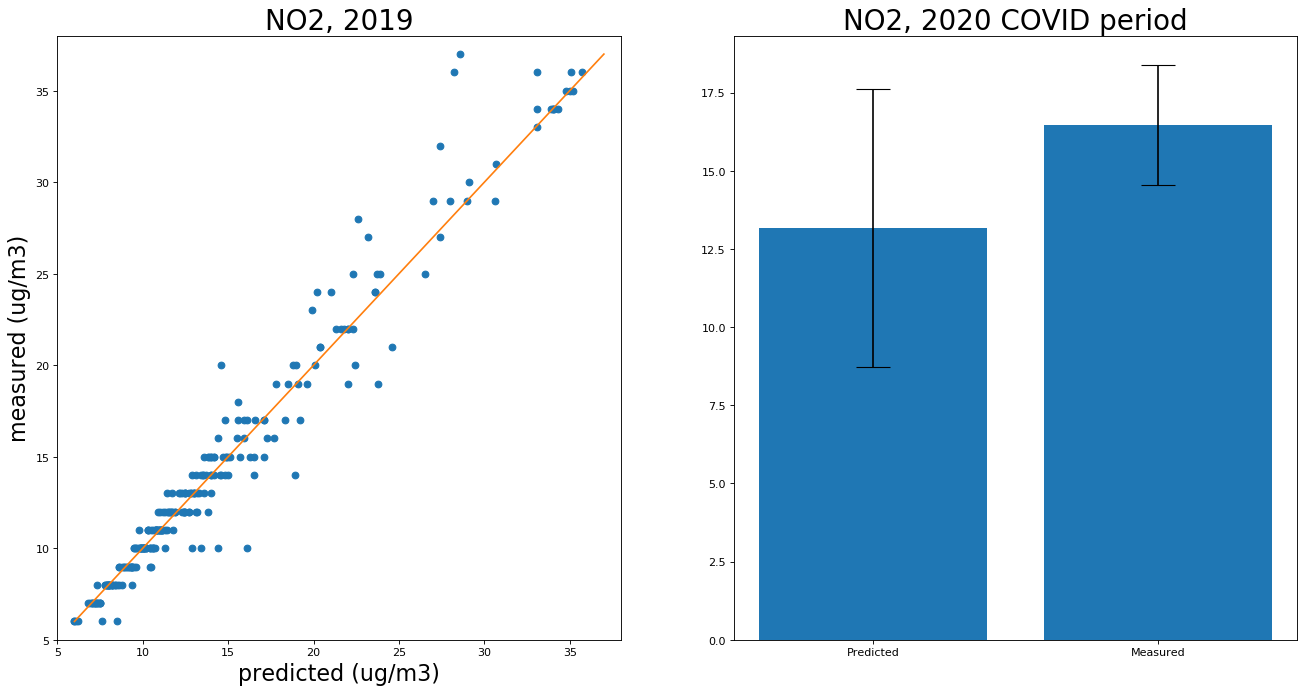

In [31]:
response = "NO2"
y = myData.loc[:,[response]]
#y_COVID = myData_COVID.loc[:,[response]]
X = myData.loc[:,['Temp', 'RH', 'WD', 'WS', 'Pressure','day_of_year', 'day_of_week', 'hour_of_day']]
X_COVID = myData_COVID.loc[:,['Temp', 'RH', 'WD', 'WS', 'Pressure','day_of_year', 'day_of_week', 'hour_of_day']]
X.isnull().any()


X_train, X_test, y_train, y_test = train_test_split(X, y)
regr = RandomForestRegressor(max_depth=20)
regr.fit(X, y)
y_pred = regr.predict(X_test)
print(mean_squared_error(y_test,y_pred))
y_pred_COVID = regr.predict(X_COVID)
myData_COVID["predicted_NO2"] = y_pred_COVID

f, (ax1, ax3) = plt.subplots(1, 2, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')

ax1.plot(y_pred,y_test,'o',[y_pred.min(),y_test.max()],[y_pred.min(),y_test.max()],'-')
ax1.set_xlim([min(y_pred)-1,max(y_test.values)+1])
ax1.set_ylim([min(y_pred)-1,max(y_test.values)+1])
ax1.set_title(response+', 2019', fontsize = 25)
ax1.set_xlabel('predicted (ug/m3)', fontsize = 20)
ax1.set_ylabel('measured (ug/m3)', fontsize = 20)

y_pred_COVID_mean, y_pred_COVID_sd = np.mean(y_pred_COVID), np.sqrt(np.var(y_pred_COVID))
y_COVID_mean, y_COVID_sd = np.mean(y_COVID.values), np.sqrt(np.var(y_COVID.values))
error = [y_pred_COVID_sd,y_COVID_sd]
ax3.bar(["Predicted","Measured"],[y_pred_COVID_mean,y_COVID_mean],
       yerr=error,
       align='center',
       ecolor='black',
       capsize=15)
ax3.set_title(response+', 2020 COVID period', fontsize = 25)
#ax3.set_xlabel('predicted', fontsize = 20)

In [38]:
y_pred_COVID

array([17.3, 16.6, 15.7, 17.5, 17.7, 17.1, 19.3, 18.2, 13.4, 20.7, 17. ,
       19.2, 16.7, 17.9, 17.8, 19.4, 20.5, 18. , 22. , 19.8, 24.8, 24. ,
       24.1, 22.2, 14.4, 21.9, 16.8, 20.1, 18.7, 15.6, 19. , 20.4, 20.6,
       20.3, 16.5, 16. , 17.5, 18.9, 18. , 18.2, 19.6, 17. , 17.6, 20. ,
       18.5, 20.4, 19.9, 18.2, 21.1, 20.4, 17.1, 17.7, 23.7, 21.3, 17.3,
       22.7, 17.1, 19.1, 18.8, 22.5, 17.1, 19.3, 20. , 18.8, 17.5, 19.3,
       17.9, 18.1, 19.1, 19.1, 18.4, 17. , 17. , 14.7, 19.1, 20.5, 19.1,
       18.8, 15.8, 15.5, 17.8, 16.1, 15.4, 16.6, 16.5, 16.6, 17.1, 16.6,
       19.5, 20.1, 20.6, 16.8, 15. , 15.8, 20. , 20. , 21.4, 19.4, 19.5,
       19.5, 22.7, 21.1, 23.5, 19.9, 14.7, 21.1, 20.6, 16.6, 24.6, 22.2,
       20.6, 18.8, 17.8, 17.1, 16.2, 20.7, 18.8, 22.7, 21.9, 22.6,  8.8,
        9. ,  8.7,  9. ,  9. ,  9. , 21.4, 24.7, 24.7, 21.1, 17. , 17. ,
       17. , 16.6, 16.6, 21.8, 21.1, 15.4,  8.4,  8.1,  8.2,  8. ,  7. ,
        7.1,  6.8,  7.4,  7.1,  7.3,  7.7,  8.7,  8

In [37]:
myData_COVID

,Unnamed: 0,Org,SO4,NO3,NH4,Chl,PM1,PM2.5,O3,SO2,...,NOx,Temp,RH,WD,WS,Pressure,day_of_year,day_of_week,hour_of_day,predicted_NO2
0,2020-01-24 00:00:00,3.42741,1.122760,2.292180,0.857681,0.055636,11.0,40.0,30.0,15.0,...,17.0,8.366,100.000,187.039,0.733,101.567,24,4,0,17.3
1,2020-01-24 01:00:00,2.32983,1.015470,1.919520,0.619063,0.014387,14.0,19.0,40.0,15.0,...,16.0,8.279,100.000,98.278,0.406,101.570,24,4,1,16.6
2,2020-01-24 02:00:00,2.11774,0.665224,1.556590,0.542784,0.032413,9.0,19.0,63.0,15.0,...,14.0,8.112,100.000,135.793,1.317,101.533,24,4,2,15.7
3,2020-01-24 03:00:00,1.17763,0.698396,0.937688,0.284116,0.021628,6.0,23.0,58.0,16.0,...,12.0,7.894,100.000,271.798,0.860,101.535,24,4,3,17.5
4,2020-01-24 04:00:00,1.50229,0.999536,1.947970,0.610505,0.019699,7.0,15.0,55.0,15.0,...,12.0,7.748,100.000,83.141,0.743,101.558,24,4,4,17.7
5,2020-01-24 05:00:00,1.36019,0.883876,1.656530,0.734231,0.011074,5.0,14.0,50.0,15.0,...,13.0,7.734,100.000,104.601,0.862,101.585,24,4,5,17.1
6,2020-01-24 06:00:00,2.37817,0.994442,2.315260,0.663135,0.060463,5.0,9.0,43.0,15.0,...,14.0,7.561,100.000,41.254,0.380,101.593,24,4,6,19.3
7,2020-01-24 07:00:00,2.32128,1.183580,4.021330,1.102010,0.049458,9.0,16.0,57.0,14.0,...,14.0,7.490,100.000,33.201,0.550,101.684,24,4,7,18.2
8,2020-01-24 08:00:00,1.73035,1.167190,2.102800,0.798111,0.055318,7.0,16.0,62.0,14.0,...,13.0,7.679,100.000,181.226,0.752,101.736,24,4,8,13.4
9,2020-01-24 09:00:00,1.98873,0.979567,1.560040,0.978519,0.091766,6.0,12.0,67.0,14.0,...,12.0,7.921,100.000,272.634,0.615,101.775,24,4,9,20.7
